In [1]:
# using ollama
%pip install -U langchain-ollama
%pip install google-generativeai langchain langchain_google_genai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dotenv import load_dotenv

# Load API key from .env file
load_dotenv()

True

In [3]:
import os
import json
import re
from langchain_community.chat_models import ChatOllama
from langchain.schema import SystemMessage, HumanMessage
import google.generativeai as genai

# Step 1: Setup Gemini API
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem Statements

In [ ]:
# problem_statement = """A mail-order company wants to automate its order
# processing. The initial version of the order processing system should be accessible to customers
# via the web. Customers can also call the company by phone and interact with the system via a
# customer representative. It is highly likely that the company will enhance this system in upcoming
# years with new features.
# The system allows customers to place orders, check the status of their orders, cancel an existing
# order, and request a catalog. Customers may also return a product, but this is only possible through
# the phone, not available on the web. When placing an order, the customer identifies himself either
# by means of a customer number (for existing registered customers) or by providing his name and
# address. He then selects a number of products by giving the product number or by selecting
# products from the online catalog. For each product, information such as price, a description, and
# a picture (only on demand as they are usually high-resolution images of large size) is presented to
# the customer. Also, the availability of the product is obtained from the inventory. The customer
# indicates whether he wants to buy the product and in what quantity. When all desired products
# have been selected, the customer provides a shipping address and a credit card number and a
# billing address (if different from the shipping address). Then an overview of the ordered products
# and the total cost are presented. If the customer approves, the order is submitted. Credit card
# number, billing address, and a specification of the cost of the order are used on the invoice, which
# is forwarded to the accounting system (an existing software module). Orders are forwarded to the
# shipping company, where they are filled and shipped.
# Customers who spent over a certain amount within the past year are promoted to be gold cus-
# tomers. Gold customers have additional rights such as being able to return products in an extended
# time period as well as earning more bonus points with each purchase. In addition, in cases where
# a product is on back order, gold customers have the option to sign up for an email notification
# for when the particular product becomes available."""

In [ ]:
# problem_statement="""A patient record and scheduling system in a doctor’s office is used by the receptionists, nurses, and
# doctors. The receptionists use the system to enter new patient information when first-time
# patients visit the doctor. They also schedule all appointments. The nurses use the system to keep
# track of the results of each visit including diagnosis and medications. For each visit, free form text
# fields are used captures information on diagnosis and treatment. Multiple medications may be
# prescribed during each visit. The nurses can also access the information to print out a history of
# patient visits. The doctors primarily use the system to view patient history. The doctors may enter
# some patient treatment information and prescriptions occasionally, but most frequently they let
# the nurses enter this information. -- Each patient is assigned to a family. The head of family is
# responsible for the person with the primary medical coverage. Information about doctors is
# maintained since a family has a primary care physician, but different doctors may be the ones
# seeing the patient during the visit."""

In [ ]:
# problem_statement="""Saturn Int. management wants to improve their security measures, both for their building and on site. They would like to prevent people who are not part of the company to use their car park.
# Saturn Int. has decided to issue identity cards to all employees. Each card records the name, department and number of a company staff, and give them access to the company car park.
# Employees are asked to wear the cards while on the site. There is a barrier and a card reader placed at the entrance to the car park. When a driver drives his
# car into the car park, he/she inserts his or her identity card into the card reader. The card reader then verify the card number to see if it is known to the system. If the number is recognized, the reader sends a signal to trigger the barrier to rise. The driver can then drive his/her car into the car park.
# There is another barrier at the exit of the car park, which is automatically raised when a car wishes to leave the car park.
# A sign at the entrance display “Full” when there are no spaces in the car park. It is only switched off when a car leaves. There is another type of card for guests, which also permits access to the car park. The card records a number and the current date. Such cards may be sent out in advance, or collected from reception. All guest cards must be returned to reception when the visitor leaves Saturn Int.
# """

In [ ]:
# problem_statement="""The exercise id to design a class structure for a library system. It should fulfil those requirements:
# There are two type of users – under-aged and adults.
# Under-aged users are identified with usage of their full name and student card.
# Adult users are identified with usage of their full name and ID card.
# The library contains books.
# There is basic information about every book (title, author, etc).
# The user can borrow at most 4 books at the same time.
# There is a history of previously borrowed books for every user (along with all the dates)."""

In [49]:
problem_statement=""" 
Each customer has unique id and is linked to exactly one account. Account owns shopping cart and
orders. Customer could register as a web user to be able to buy items online. Customer is not
required to be a web user because purchases could also be made by phone or by ordering from
catalogues. Web user has login name which also serves as unique id. Web user could be in several
states - new, active, temporary blocked, or banned, and be linked to a shopping cart. Shopping cart
belongs to account.
Account owns customer orders. Customer may have no orders. Customer orders are sorted and
unique. Each order could refer to several payments, possibly none. Every payment has unique id
and is related to exactly one account.
Each order has current order status. Both order and shopping cart have line items linked to a
specific product. Each line item is related to exactly one product. A product could be associated to
many line items or no item at all.
"""

In [50]:
problem_statement

' \nEach customer has unique id and is linked to exactly one account. Account owns shopping cart and\norders. Customer could register as a web user to be able to buy items online. Customer is not\nrequired to be a web user because purchases could also be made by phone or by ordering from\ncatalogues. Web user has login name which also serves as unique id. Web user could be in several\nstates - new, active, temporary blocked, or banned, and be linked to a shopping cart. Shopping cart\nbelongs to account.\nAccount owns customer orders. Customer may have no orders. Customer orders are sorted and\nunique. Each order could refer to several payments, possibly none. Every payment has unique id\nand is related to exactly one account.\nEach order has current order status. Both order and shopping cart have line items linked to a\nspecific product. Each line item is related to exactly one product. A product could be associated to\nmany line items or no item at all.\n'

### Step 1 - Identify Actions

In [51]:
def identify_actions(problem_statement):
    """
    Identifies potential actions from a given problem statement using Gemini API with CoT prompting.
    """
    prompt = f"""
    You are an expert software analyst. Your task is to identify **key actions** from the given problem statement. 
    Follow this detailed step-by-step process carefully to ensure accurate results:

    ### **Step-by-Step Approach:**
    1. **Identify Core Actions:**
       - Carefully analyze the problem statement for any **verbs** or **actions** that represent key behaviors of the system.
       - Focus on verbs or phrases that reflect meaningful state changes or user interactions.
       - Ignore vague, ambiguous, or irrelevant actions unless they provide useful context.

    2. **Group and Format Actions:**
       - Convert identified actions into **camelCase**.
       - Ensure that the actions are logically grouped and contextually accurate.
       - Remove any redundant or overlapping actions.

    3. **Ensure Completeness and Relevance:**
       - Ensure that the identified actions reflect the actual flow of the system.
       - Remove any vague or incomplete terms.

    ### **Output Format (Strict JSON):**
    Return only valid JSON in the following format:
    {{
        "actions": ["action1", "action2", "action3"]
    }}

    **Problem Statement:**
    {problem_statement}

    Now extract the key actions based on the above rules.
    """

    try:
        # Generate response using Gemini model
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        
        # Debugging: Print raw response
        response_text = response.text.strip()
        print("Raw Response from Gemini:\n", response_text)

        # Clean up response (remove markdown formatting)
        cleaned_text = re.sub(r"```json|```", "", response_text).strip()


        # Additional Debugging: Print cleaned text before parsing
        print("Cleaned JSON:\n", repr(cleaned_text))  # Use repr() to detect hidden characters

        # Check if cleaned_text is empty
        if not cleaned_text:
            print("Error: Cleaned JSON is empty. Cannot parse.")
            return {}

        # Parse JSON safely
        output = json.loads(cleaned_text)
        return output.get("actions", [])

    except json.JSONDecodeError as e:
        print("JSON parsing error:", str(e))
        return {}

    except Exception as e:
        print("Error:", str(e))
        return {}

# Identify actions using Gemini
identified_actions = identify_actions(problem_statement)

# Display Result
print("\nIdentified Actions:", identified_actions)

Raw Response from Gemini:
 ```json
{
  "actions": ["registerWebUser", "makePurchase", "login", "updateOrderStatus", "addLineItemToCart", "addLineItemToOrder", "makePayment", "changeUserState"]
}
```
Cleaned JSON:
 '{\n  "actions": ["registerWebUser", "makePurchase", "login", "updateOrderStatus", "addLineItemToCart", "addLineItemToOrder", "makePayment", "changeUserState"]\n}'

Identified Actions: ['registerWebUser', 'makePurchase', 'login', 'updateOrderStatus', 'addLineItemToCart', 'addLineItemToOrder', 'makePayment', 'changeUserState']


### Step 2 - Define Activity Nodes

In [52]:
def define_activity_nodes(actions):
    """
    Identifies activity nodes from given actions using Gemini API with CoT prompting.
    """
    prompt = f"""
    You are an expert software analyst. Your task is to define **activity nodes** for an activity diagram 
    based on the identified actions. Follow this structured step-by-step process carefully:

    ### **Step-by-Step Approach:**
    1. **Map Actions to Nodes:**
       - For each identified action, create a corresponding node.
       - Ensure each node reflects the system’s behavior accurately.

    2. **Classify Nodes:**
       - If it represents the starting point → classify it as an **Initial Node**.
       - If it represents a state change or process → classify it as an **Action Node**.
       - If it represents a branching point → classify it as a **Decision Node**.
       - If it merges control flow → classify it as a **Merge Node**.
       - If it splits control into parallel flows → classify it as a **Fork Node**.
       - If it synchronizes control flow → classify it as a **Join Node**.
       - If it represents the termination point → classify it as a **Final Node**.

    3. **Ensure Completeness and Logical Flow:**
       - Start from the **Initial Node**.
       - Include all major actions.
       - Ensure proper transitions between nodes.
       - Conclude with a **Final Node**.

    4. **Output Format (Strict JSON):**
    Return only valid JSON in the following format:
    {{
        "nodes": [
            {{"type": "Initial Node", "name": "start"}},
            {{"type": "Action Node", "name": "issueTicket"}},
            {{"type": "Decision Node", "name": "isPaymentValid"}},
            {{"type": "Merge Node", "name": "mergeValidation"}},
            {{"type": "Fork Node", "name": "splitPaymentMethods"}},
            {{"type": "Join Node", "name": "syncCompletion"}},
            {{"type": "Final Node", "name": "end"}}
        ]
    }}

    **Identified Actions:**
    {actions}

    Now define the activity nodes based on the above rules.
    """

    try:
        # Generate response using Gemini model
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        
        # Debugging: Print raw response
        response_text = response.text.strip()
        # print("Raw Response from Gemini:\n", response_text)

        # Clean up response (remove markdown formatting)
        cleaned_text = re.sub(r"```json|```", "", response_text).strip()

        # Additional Debugging: Print cleaned text before parsing
        # print("Cleaned JSON:\n", repr(cleaned_text))

        # Check if cleaned_text is empty
        if not cleaned_text:
            print("Error: Cleaned JSON is empty. Cannot parse.")
            return {}

        # Parse JSON safely
        output = json.loads(cleaned_text)
        return output.get("nodes", [])

    except json.JSONDecodeError as e:
        print("JSON parsing error:", str(e))
        return {}

    except Exception as e:
        print("Error:", str(e))
        return {}

# Generate Activity Nodes using Gemini
identified_nodes = define_activity_nodes(identified_actions)

# Display Result
print("\nIdentified Activity Nodes:", identified_nodes)


Identified Activity Nodes: [{'type': 'Initial Node', 'name': 'start'}, {'type': 'Action Node', 'name': 'registerWebUser'}, {'type': 'Action Node', 'name': 'login'}, {'type': 'Action Node', 'name': 'addLineItemToCart'}, {'type': 'Action Node', 'name': 'makePurchase'}, {'type': 'Action Node', 'name': 'addLineItemToOrder'}, {'type': 'Action Node', 'name': 'makePayment'}, {'type': 'Decision Node', 'name': 'isPaymentValid'}, {'type': 'Action Node', 'name': 'updateOrderStatus'}, {'type': 'Action Node', 'name': 'changeUserState'}, {'type': 'Merge Node', 'name': 'mergePaymentValidation'}, {'type': 'Final Node', 'name': 'end'}]


### Step 3 - Establish Control Flow

In [53]:
def establish_control_flow(nodes):
    """
    Establishes control flow between activity nodes using Gemini API with CoT prompting.
    """
    prompt = f"""
    You are an expert software analyst. Your task is to establish **control flow** between the defined activity nodes 
    for an activity diagram. Follow this structured step-by-step process carefully:

    ### **Step-by-Step Approach:**
    1. **Establish Transition Rules:**
       - Ensure a clear transition from the **Initial Node** to the first **Action Node**.
       - Maintain logical progression between nodes.
       - Ensure a proper transition to the **Final Node** at the end.

    2. **Map Conditions and Decision Flow:**
       - If a node represents a decision point → create a **Decision Node**.
       - Define the possible outcomes for the decision and link them to corresponding nodes.
       - If the flow merges after a decision → create a **Merge Node**.

    3. **Handle Parallel and Synchronous Flow:**
       - If multiple flows can occur simultaneously → create a **Fork Node**.
       - Ensure synchronization → use a **Join Node** after all parallel flows complete.

    4. **Ensure Logical Consistency:**
       - All nodes should be linked correctly without any dead ends.
       - Ensure there are no unconnected nodes.

    5. **Remove Redundancies:**
       - Remove repeated or overlapping transitions.

    ### **Output Format (Strict JSON):**
    Return only valid JSON in the following format:
    {{
        "control_flow": [
            {{"source": "start", "target": "issueTicket", "type": "direct"}},
            {{"source": "issueTicket", "target": "isPaymentValid", "type": "decision"}},
            {{"source": "isPaymentValid", "target": "completeTransaction", "type": "merge"}},
            {{"source": "completeTransaction", "target": "end", "type": "direct"}}
        ]
    }}

    **Defined Nodes:**
    {nodes}

    Now establish the control flow between these nodes.
    """

    try:
        # Generate response using Gemini model
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        
        # Debugging: Print raw response
        response_text = response.text.strip()
        print("Raw Response from Gemini:\n", response_text)

        # Clean up response (remove markdown formatting)
        cleaned_text = re.sub(r"```json|```", "", response_text).strip()

        # Additional Debugging: Print cleaned text before parsing
        print("Cleaned JSON:\n", repr(cleaned_text))

        # Check if cleaned_text is empty
        if not cleaned_text:
            print("Error: Cleaned JSON is empty. Cannot parse.")
            return {}

        # Parse JSON safely
        output = json.loads(cleaned_text)
        return output.get("control_flow", [])

    except json.JSONDecodeError as e:
        print("JSON parsing error:", str(e))
        return {}

    except Exception as e:
        print("Error:", str(e))
        return {}

# Generate Control Flow using Gemini
control_flow = establish_control_flow(identified_nodes)

# Display Result
print("\nGenerated Control Flow:", control_flow)

Raw Response from Gemini:
 ```json
{
  "control_flow": [
    {"source": "start", "target": "registerWebUser", "type": "direct"},
    {"source": "registerWebUser", "target": "login", "type": "direct"},
    {"source": "login", "target": "addLineItemToCart", "type": "direct"},
    {"source": "addLineItemToCart", "target": "makePurchase", "type": "direct"},
    {"source": "makePurchase", "target": "makePayment", "type": "direct"},
    {"source": "makePayment", "target": "isPaymentValid", "type": "direct"},
    {"source": "isPaymentValid", "target": "completeTransaction", "type": "true"},
    {"source": "isPaymentValid", "target": "updateOrderStatus", "type": "false"},
    {"source": "updateOrderStatus", "target": "mergePaymentValidation", "type": "direct"},
    {"source": "completeTransaction", "target": "mergePaymentValidation", "type": "direct"},
    {"source": "mergePaymentValidation", "target": "changeUserState", "type": "direct"},
    {"source": "changeUserState", "target": "end", "ty

### Step 4 - Generate plantUML Script

In [54]:
import os

def generate_plantuml(nodes, control_flow, output_file="before.puml"):
    """
    Generates a PlantUML activity diagram script from identified nodes and control flow.
    """
    
    prompt = f"""
    You are an expert UML Diagram Developer. Your task is to generate plantUML script for defined activity nodes and control flows for an activity diagram.
    Follow these syntax rules strictly to avoid any errors.

 **PlantUML Syntax Rules** (Use Exactly):

1. **Start and end the diagram** with:
   - `@startuml` and `@enduml`
   - `start` and `stop` must exist in every diagram

2. **Action Nodes** must use `:Action Description;` (semicolon required)

3. **Decision Nodes** must follow this format:
    if (Condition?) then (yes) :Action A; else (no) :Action B; endif

4. **Loops** must be written like this:
    while (Condition?) is (yes) :Repeated Action; endwhile


5. **Do NOT** use:
- `break`, `continue`, `goto`, `{{}}`, Python/C-style syntax
- control structures not supported by PlantUML

6. Use **fork/join nodes** to model parallel execution:
fork 
    :Task A; 
fork again 
    :Task B; 
end fork

7. Every `if` must have a matching `endif`, and every `while` a matching `endwhile`.

✅ **Must Include in the Diagram**:

- Initial and Final Nodes
- Decision and Merge Nodes
- Loops if needed
- Fork and Join for concurrent/parallel actions
- Clear sequence of actions, correctness of logic
- Handle exceptions if present in the logic

🔍 **Example – Fork/Join Pattern**:

fork :Process payment; fork again :Send confirmation email; end fork

✅ **Example of Valid Syntax**:

@startuml start 
:Identify Customer; 
if (Is customer registered?) then (yes) 
    :Retrieve customer info; 
else (no) 
    :Register new customer; 
endif 
while (More products?) is (yes) 
    :Select product; 
    :Add to cart; 
endwhile 
:Enter shipping info; 
:Make payment; 
stop 
@enduml

Now, using the problem statement below, generate a **complete, logically correct, and syntactically valid** PlantUML activity diagram.

    **Defined Nodes:**
    {nodes}

    **Defined Control_flow**
    {control_flow}

    Now generate the PlantUML activity diagram. 
    **Return only the PlantUML code.**  
    """
    

    try:
        # Generate response using Gemini model
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        
        # Debugging: Print raw response
        response_text = response.text.strip()
        print("Raw Response from Gemini:\n", response_text)

        # Clean up response (remove markdown formatting)
        cleaned_text = re.sub(r"```plantuml|```", "", response_text).strip()

        # Additional Debugging: Print cleaned text before saving
        print("Cleaned Code:\n", repr(cleaned_text))

        # ✅ Save to file
        with open(output_file, "w") as file:
            file.write(cleaned_text)

        print(f"✅ PlantUML file '{output_file}' generated successfully.")

        return cleaned_text

    except Exception as e:
        print("Error:", str(e))
        return None

# Generate UML
plantuml_code = generate_plantuml(identified_nodes, control_flow)

Raw Response from Gemini:
 ```plantuml
@startuml
start

:registerWebUser;
:login;
:addLineItemToCart;
:makePurchase;
:makePayment;

if (isPaymentValid?) then (yes)
    :completeTransaction;
else (no)
    :updateOrderStatus;
endif

:mergePaymentValidation;
:changeUserState;

stop
@enduml
```
Cleaned Code:
 '@startuml\nstart\n\n:registerWebUser;\n:login;\n:addLineItemToCart;\n:makePurchase;\n:makePayment;\n\nif (isPaymentValid?) then (yes)\n    :completeTransaction;\nelse (no)\n    :updateOrderStatus;\nendif\n\n:mergePaymentValidation;\n:changeUserState;\n\nstop\n@enduml'
✅ PlantUML file 'before.puml' generated successfully.


In [55]:
plantuml_code

'@startuml\nstart\n\n:registerWebUser;\n:login;\n:addLineItemToCart;\n:makePurchase;\n:makePayment;\n\nif (isPaymentValid?) then (yes)\n    :completeTransaction;\nelse (no)\n    :updateOrderStatus;\nendif\n\n:mergePaymentValidation;\n:changeUserState;\n\nstop\n@enduml'

### Step 5 - Generate clarification questions

In [56]:
import ollama
import json
import re

def generate_clarification_questions(problem_statement, plantuml_code):
    """
    Generate clarification questions from an activity diagram using ClarifyGPT approach.
    """
    prompt = f""" 
You are a UML modeling expert simulating the ClarifyGPT framework. Your task is to analyze the following PlantUML activity diagram script and its corresponding problem statement, and generate **any number of clarification questions**.

Your questions must help refine the diagram by identifying the following issues:

1. **Completeness**:
- Are all key actions and control flows from the problem statement present in the diagram?
- Is any part of the system behavior or domain logic missing?

2. **Domain Clarification**:
- Are there parts of the requirements that are unclear or ambiguous and may affect the behavior of the diagram?
- Are the responsibilities and decisions modeled precisely?

3. **Syntactic Correctness**:
- Is the activity diagram using correct PlantUML syntax?
- Are all control structures (e.g., `if/endif`, `while/endwhile`, `fork/end fork`) used properly?

4. **Semantic Correctness**:
- Does the structure and behavior of the AD align logically with the real-world process described in the problem statement?
- Are control flows like decision-making and parallel execution accurately modeled?

5. **Requirement Coverage**:
- Are there any behaviors, conditions, or decision flows in the problem statement that are missing or not addressed in the activity diagram?

---

Generate **any number of clear and actionable questions** that point out potential areas needing clarification or correction. Refer to specific actions, decisions, or transitions when possible.

### Problem Statement:
{problem_statement}

### PlantUML Activity Diagram Script:
{plantuml_code}

Please output exactly as a JSON array of strings like this:

### Output Format (Strict JSON):
[
  "Question 1: ...",
  "Question 2: ...",
  "Question 3: ...",
  "Question 4: ...",
  "Question 5: ...",
  "..."
]
Now generate ONLY JSON output...
"""

    # try:
    #     model = genai.GenerativeModel("gemini-1.5-flash")
    #     response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
    #     response_text = response.text.strip()
    #     questions = json.loads(re.sub(r"```json|```", "", response_text))
    #     return questions

    # except Exception as e:
    #     print("❌ Error generating questions:", str(e))
    #     return []

    try:
        response = ollama.chat(model="llama3.2", messages=[{"role": "user", "content": prompt}])
        # response = ollama.chat(model="deepseek-r1:1.5b", messages=[{"role": "user", "content": prompt}])
        response_text = response["message"]["content"].strip()
        questions = json.loads(re.sub(r"```json|```", "", response_text)) 
        # questions = [line for line in response_text.splitlines() if line.startswith("Question")]
        return questions
    except Exception as e:
        print("Error generating questions:", str(e))
        return []


In [57]:
def answer_clarification_questions(problem_statement, plantuml_script, questions):
    """
    Uses LLM to answer clarification questions about an activity diagram.
    """
    q_block = "\n".join(questions)

    prompt = f"""
You are an expert UML analyst. Based on the problem statement and PlantUML activity diagram, answer the following clarification questions.

## Problem Statement:
{problem_statement}

## PlantUML:
{plantuml_script}

## Questions:
{q_block}

## Provide direct answers:
"""

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        return response.text.strip().splitlines()
    except Exception as e:
        print("❌ Error generating answers:", str(e))
        return []


In [58]:
def regenerate_ad_from_feedback(problem_statement, previous_plantuml, questions, answers, output_file):
    """
    Regenerates the activity diagram using ClarifyGPT-style feedback and clarification.
    """
    feedback_pairs = "\n".join(f"{q} Answer: {a}" for q, a in zip(questions, answers))

    prompt = f"""
You are a senior UML designer. Improve the following PlantUML activity diagram using clarifying answers to improve completeness and correctness.
Follow these syntax rules strictly to avoid any errors.

 **PlantUML Syntax Rules** (Use Exactly):

1. **Start and end the diagram** with:
   - `@startuml` and `@enduml`
   - `start` and `stop` must exist in every diagram

2. **Action Nodes** must use `:Action Description;` (semicolon required)

3. **Decision Nodes** must follow this format:
    if (Condition?) then (yes) :Action A; else (no) :Action B; endif

4. **Loops** must be written like this:
    while (Condition?) is (yes) :Repeated Action; endwhile


5. **Do NOT** use:
- `break`, `continue`, `goto`, `{{}}`, Python/C-style syntax
- control structures not supported by PlantUML

6. Use **fork/join nodes** to model parallel execution:
fork 
    :Task A; 
fork again 
    :Task B; 
end fork

7. Every `if` must have a matching `endif`, and every `while` a matching `endwhile`.

✅ **Must Include in the Diagram**:

- Initial and Final Nodes
- Decision and Merge Nodes
- Loops if needed
- Fork and Join for concurrent/parallel actions
- Clear sequence of actions, correctness of logic
- Handle exceptions if present in the logic

🔍 **Example – Fork/Join Pattern**:

fork :Process payment; fork again :Send confirmation email; end fork

---

✅ **Example of Valid Syntax**:

@startuml start 
:Identify Customer; 
if (Is customer registered?) then (yes) 
    :Retrieve customer info; 
else (no) 
    :Register new customer; 
endif 
while (More products?) is (yes) 
    :Select product; 
    :Add to cart; 
endwhile 
:Enter shipping info; 
:Make payment; 
stop 
@enduml

Now, using the problem statement below, generate a **complete, logically correct, and syntactically valid** PlantUML activity diagram.

## Problem Statement:
{problem_statement}

## Original PlantUML:
{previous_plantuml}

## Clarification Feedback:
{feedback_pairs}

## Instructions:
- Fix logical issues.
- Add or fix fork/join/decision nodes if needed.
- Return only the PlantUML code.
"""

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        cleaned_text = re.sub(r"```(plantuml|uml|text)?|```", "", response.text.strip()).strip()

        with open(output_file, "w") as file:
            file.write(cleaned_text)

        return cleaned_text
    except Exception as e:
        print("❌ Error regenerating diagram:", str(e))
        return ""


In [59]:
def clarifygpt_refinement_loop(problem_statement, initial_plantuml):

    current_diagram = initial_plantuml
    round_num = 1

    print(f"\n🔁 ClarifyGPT Evaluation and Refinement")

    # Generate questions
    questions = generate_clarification_questions(problem_statement, current_diagram)
    print("\n🧠 Questions:")
    for q in questions:
        print(q)

    # Get answers
    answers = answer_clarification_questions(problem_statement, current_diagram, questions)
    print("\n🤖 Answers:")
    for a in answers:
        print(a)

    # Regenerate diagram
    output_file = f"clarifiedAD.puml"
    # output_file = f"clarifiedAD_llama_round{round_num}.puml"
    # output_file = f"clarifiedAD_deepseek_round{round_num}.puml"
    current_diagram = regenerate_ad_from_feedback(
        problem_statement, current_diagram, questions, answers, output_file
    )

    print(f"\n✅ Diagram saved to {output_file}")

    return current_diagram
    
final_diagram = clarifygpt_refinement_loop(problem_statement, plantuml_code)


🔁 ClarifyGPT Evaluation and Refinement

🧠 Questions:
Clarification Question: Is the 'registerWebUser' action correctly linked to a shopping cart, as it is not explicitly stated in the problem statement?
Question 2: Are the responsibilities of 'changeUserState' and 'mergePaymentValidation' clearly defined and accurately represented in the activity diagram?
Clarification Question: Does the 'if (isPaymentValid?) then (yes)' condition correctly handle cases where a payment is invalid, and should this be a separate step or part of 'updateOrderStatus'?
Question 3: Is the 'makePurchase' action accurately represented as a single step that encompasses both adding line items to the cart and making payments?
Clarification Question: How does the activity diagram handle cases where a customer has no orders or purchases, and should these scenarios be explicitly modeled?
Question 4: Are all decision-making flows (e.g., 'isPaymentValid?') clearly defined and properly used in the activity diagram?
Que

In [23]:
problem_statement

'Saturn Int. management wants to improve their security measures, both for their building and on site. They would like to prevent people who are not part of the company to use their car park.\nSaturn Int. has decided to issue identity cards to all employees. Each card records the name, department and number of a company staff, and give them access to the company car park.\nEmployees are asked to wear the cards while on the site. There is a barrier and a card reader placed at the entrance to the car park. When a driver drives his\ncar into the car park, he/she inserts his or her identity card into the card reader. The card reader then verify the card number to see if it is known to the system. If the number is recognized, the reader sends a signal to trigger the barrier to rise. The driver can then drive his/her car into the car park.\nThere is another barrier at the exit of the car park, which is automatically raised when a car wishes to leave the car park.\nA sign at the entrance disp

### Step 6 - Evaluation

In [24]:
import json
import pandas as pd
import google.generativeai as genai

def extract_json_from_response(text):
    """
    Extract the first valid JSON object from the response using regex.
    """
    try:
        match = re.search(r'\{[\s\S]*?\}', text)
        if match:
            return json.loads(match.group())
    except json.JSONDecodeError as e:
        print("JSON decoding error:", e)
    return None
def evaluate_diagram_with_llm(problem_statement: str, plantuml_script: str) -> dict:
    """
    Evaluates a PlantUML activity diagram using Gemini API and returns scores on 5 metrics.
    """
    prompt = f"""
You are an expert UML evaluator.

Evaluate the following activity diagram written in PlantUML against the problem statement on five metrics.

Problem Statement:
{problem_statement}

PlantUML Script:
{plantuml_script}

Evaluate the diagram and provide a score between 0 and 5 for each of the following metrics:
1. Completeness – Does it capture all necessary actions and flows from the problem?
2. Correctness – Are the flows logically correct and free of errors?
3. Adherence to UML Standards – Are UML syntax and constructs correctly used?
4. Understandability – Is the diagram clear and easy to follow?
5. Terminology – Are standard UML terms and appropriate naming conventions used?

Respond with a JSON object like this:
{{
  "completeness": 4,
  "correctness": 5,
  "adherence_to_standard": 5,
  "understandability": 4,
  "terminology": 5
}}
Only output the JSON.
"""
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
    scores = extract_json_from_response(response.text)

    if scores is None:
            raise ValueError(f"Failed to parse JSON from response:\n{response.text}")

    # Optional: Validate keys
    expected_keys = {"completeness", "correctness", "adherence_to_standard", "understandability", "terminology"}
    if not expected_keys.issubset(scores.keys()):
        raise ValueError(f"Missing expected keys in score response: {scores}")

    return scores


def evaluate_activity_diagrams(problem_statement, diagram_files_dict, output_excel_path="result_problem3.xlsx"):
    """
    Evaluates multiple activity diagrams against the problem statement.

    Args:
        problem_statement (str): The problem statement to evaluate against.
        diagrams_dict (dict): Dictionary of form { 'LLM Name': 'path/to/plantuml_file.txt' }
        output_excel_path (str): Output Excel file path.

    Returns:
        pd.DataFrame: DataFrame of evaluation scores.
    """
    results = []

    for llm_name, filepath in diagram_files_dict.items():
        print(f"Evaluating diagram from: {llm_name}")
        try:
            with open(filepath, 'r') as file:
                plantuml_script = file.read()
        except FileNotFoundError:
            print(f"File not found for {llm_name}: {filepath}")
            continue

        scores = evaluate_diagram_with_llm(problem_statement, plantuml_script)
        row = {
            "LLM": llm_name,
            "Completeness": scores["completeness"],
            "Correctness": scores["correctness"],
            "Adherence to Standard": scores["adherence_to_standard"],
            "Understandability": scores["understandability"],
            "Terminology": scores["terminology"],
        }
        results.append(row)

    df = pd.DataFrame(results)
    df.to_excel(output_excel_path, index=False)
    print(f"Evaluation saved to: {output_excel_path}")
    return df


diagrams = {
    "Before": r"I:\STUDY\MTECH\MTECH STUDY MATERIAL\MINORPROJECT\IMPLEMENTATION\LANGCHAIN\evaluateActivity\problem3_before.puml",
    "Gemini": r"I:\STUDY\MTECH\MTECH STUDY MATERIAL\MINORPROJECT\IMPLEMENTATION\LANGCHAIN\evaluateActivity\problem3_gemini_round1.puml",
    "LLaMA-3": r"I:\STUDY\MTECH\MTECH STUDY MATERIAL\MINORPROJECT\IMPLEMENTATION\LANGCHAIN\evaluateActivity\problem3_llama_round1.puml",
    "Deepseek": r"I:\STUDY\MTECH\MTECH STUDY MATERIAL\MINORPROJECT\IMPLEMENTATION\LANGCHAIN\evaluateActivity\problem3_deepseek_round1.puml",
}

evaluate_activity_diagrams(problem_statement, diagrams)



Evaluating diagram from: Before
Evaluating diagram from: Gemini
Evaluating diagram from: LLaMA-3
Evaluating diagram from: Deepseek
Evaluation saved to: result_problem3.xlsx


,LLM,Completeness,Correctness,Adherence to Standard,Understandability,Terminology
0,Before,2,3,4,3,4
1,Gemini,4,4,5,4,5
2,LLaMA-3,4,4,5,4,5
3,Deepseek,4,4,5,4,5


In [60]:
# Example placeholder dictionary for 5 problem statements
problem_statements = {
    "problem1": """A mail-order company wants to automate its order
processing. The initial version of the order processing system should be accessible to customers
via the web. Customers can also call the company by phone and interact with the system via a
customer representative. It is highly likely that the company will enhance this system in upcoming
years with new features.
The system allows customers to place orders, check the status of their orders, cancel an existing
order, and request a catalog. Customers may also return a product, but this is only possible through
the phone, not available on the web. When placing an order, the customer identifies himself either
by means of a customer number (for existing registered customers) or by providing his name and
address. He then selects a number of products by giving the product number or by selecting
products from the online catalog. For each product, information such as price, a description, and
a picture (only on demand as they are usually high-resolution images of large size) is presented to
the customer. Also, the availability of the product is obtained from the inventory. The customer
indicates whether he wants to buy the product and in what quantity. When all desired products
have been selected, the customer provides a shipping address and a credit card number and a
billing address (if different from the shipping address). Then an overview of the ordered products
and the total cost are presented. If the customer approves, the order is submitted. Credit card
number, billing address, and a specification of the cost of the order are used on the invoice, which
is forwarded to the accounting system (an existing software module). Orders are forwarded to the
shipping company, where they are filled and shipped.
Customers who spent over a certain amount within the past year are promoted to be gold cus-
tomers. Gold customers have additional rights such as being able to return products in an extended
time period as well as earning more bonus points with each purchase. In addition, in cases where
a product is on back order, gold customers have the option to sign up for an email notification
for when the particular product becomes available.""",
    "problem2": """A patient record and scheduling system in a doctor’s office is used by the receptionists, nurses, and
doctors. The receptionists use the system to enter new patient information when first-time
patients visit the doctor. They also schedule all appointments. The nurses use the system to keep
track of the results of each visit including diagnosis and medications. For each visit, free form text
fields are used captures information on diagnosis and treatment. Multiple medications may be
prescribed during each visit. The nurses can also access the information to print out a history of
patient visits. The doctors primarily use the system to view patient history. The doctors may enter
some patient treatment information and prescriptions occasionally, but most frequently they let
the nurses enter this information. -- Each patient is assigned to a family. The head of family is
responsible for the person with the primary medical coverage. Information about doctors is
maintained since a family has a primary care physician, but different doctors may be the ones
seeing the patient during the visit.""",
    "problem3": """Saturn Int. management wants to improve their security measures, both for their building and on site. They would like to prevent people who are not part of the company to use their car park.
Saturn Int. has decided to issue identity cards to all employees. Each card records the name, department and number of a company staff, and give them access to the company car park.
Employees are asked to wear the cards while on the site. There is a barrier and a card reader placed at the entrance to the car park. When a driver drives his
car into the car park, he/she inserts his or her identity card into the card reader. The card reader then verify the card number to see if it is known to the system. If the number is recognized, the reader sends a signal to trigger the barrier to rise. The driver can then drive his/her car into the car park.
There is another barrier at the exit of the car park, which is automatically raised when a car wishes to leave the car park.
A sign at the entrance display “Full” when there are no spaces in the car park. It is only switched off when a car leaves. There is another type of card for guests, which also permits access to the car park. The card records a number and the current date. Such cards may be sent out in advance, or collected from reception. All guest cards must be returned to reception when the visitor leaves Saturn Int.
""",
    "problem4": """The exercise id to design a class structure for a library system. It should fulfil those requirements:
There are two type of users – under-aged and adults.
Under-aged users are identified with usage of their full name and student card.
Adult users are identified with usage of their full name and ID card.
The library contains books.
There is basic information about every book (title, author, etc).
The user can borrow at most 4 books at the same time.
There is a history of previously borrowed books for every user (along with all the dates).""",
    "problem5": """Each customer has unique id and is linked to exactly one account. Account owns shopping cart and
orders. Customer could register as a web user to be able to buy items online. Customer is not
required to be a web user because purchases could also be made by phone or by ordering from
catalogues. Web user has login name which also serves as unique id. Web user could be in several
states - new, active, temporary blocked, or banned, and be linked to a shopping cart. Shopping cart
belongs to account.
Account owns customer orders. Customer may have no orders. Customer orders are sorted and
unique. Each order could refer to several payments, possibly none. Every payment has unique id
and is related to exactly one account.
Each order has current order status. Both order and shopping cart have line items linked to a
specific product. Each line item is related to exactly one product. A product could be associated to
many line items or no item at all."""
}

### Step 7 - Final Evaluation

In [61]:
import json
import pandas as pd
import google.generativeai as genai
import os
import re

def extract_json_from_response(text):
    try:
        match = re.search(r'\{[\s\S]*?\}', text)
        if match:
            return json.loads(match.group())
    except json.JSONDecodeError as e:
        print("JSON decoding error:", e)
    return None

def evaluate_diagram_with_llm(problem_statement: str, plantuml_script: str) -> dict:
    prompt = f"""
You are an expert UML evaluator.

Evaluate the following activity diagram written in PlantUML against the problem statement on five metrics.

Problem Statement:
{problem_statement}

PlantUML Script:
{plantuml_script}

Evaluate the diagram and provide a score between 0 and 5 for each of the following metrics:
1. Completeness – Does it capture all necessary actions and flows from the problem?
2. Correctness – Are the flows logically correct and free of errors?
3. Adherence to UML Standards – Are UML syntax and constructs correctly used?
4. Understandability – Is the diagram clear and easy to follow?
5. Terminology – Are standard UML terms and appropriate naming conventions used?

Respond with a JSON object like this:
{{
  "completeness": 4,
  "correctness": 5,
  "adherence_to_standard": 5,
  "understandability": 4,
  "terminology": 5
}}
Only output the JSON.
"""
    model = genai.GenerativeModel("gemini-1.5-flash")
    response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
    scores = extract_json_from_response(response.text)

    if scores is None:
        raise ValueError(f"Failed to parse JSON from response:\n{response.text}")

    expected_keys = {"completeness", "correctness", "adherence_to_standard", "understandability", "terminology"}
    if not expected_keys.issubset(scores.keys()):
        raise ValueError(f"Missing expected keys in score response: {scores}")

    return scores

def evaluate_all_problems(problem_statements, base_folder, output_excel="final_scores.xlsx"):
    rows = []
    for i in range(1, 6):
        problem_key = f"problem{i}"
        problem_statement = problem_statements.get(problem_key)
        if not problem_statement:
            print(f"Problem statement for {problem_key} not found. Skipping.")
            continue

        for version in ["before", "clarifiedAD"]:
            filename = f"{problem_key}_{version}.puml"
            filepath = os.path.join(base_folder, filename)
            if not os.path.isfile(filepath):
                print(f"File not found: {filepath}")
                continue

            with open(filepath, "r") as f:
                script = f.read()
            scores = evaluate_diagram_with_llm(problem_statement, script)
            row = {
                "Problem": problem_key,
                "Version": version,
                "Completeness": scores["completeness"],
                "Correctness": scores["correctness"],
                "Adherence to Standard": scores["adherence_to_standard"],
                "Understandability": scores["understandability"],
                "Terminology": scores["terminology"]
            }
            rows.append(row)

    df = pd.DataFrame(rows)
    df.to_excel(output_excel, index=False)
    print(f"All evaluations saved to {output_excel}")
    return df



# Call the function with the folder path containing .puml files
evaluate_all_problems(problem_statements, base_folder="I:/STUDY/MTECH/MTECH STUDY MATERIAL/MINORPROJECT/IMPLEMENTATION/LANGCHAIN/evaluateActivity")


All evaluations saved to final_scores.xlsx


,Problem,Version,Completeness,Correctness,Adherence to Standard,Understandability,Terminology
0,problem1,before,3,3,5,4,5
1,problem1,clarifiedAD,4,4,5,4,5
2,problem2,before,2,3,4,3,5
3,problem2,clarifiedAD,3,4,5,4,5
4,problem3,before,2,3,4,3,4
5,problem3,clarifiedAD,4,4,5,4,5
6,problem4,before,2,3,5,4,5
7,problem4,clarifiedAD,4,4,5,5,5
8,problem5,before,2,3,5,4,5
9,problem5,clarifiedAD,3,4,5,4,5


In [ ]:
import pandas as pd

def calculate_statistics(excel_file):
    # Load the evaluation results
    df = pd.read_excel(excel_file)

    # Separate before and after (clarifiedAD) results
    before_df = df[df['Version'] == 'before']
    after_df = df[df['Version'] == 'clarifiedAD']

    metrics = ["Completeness", "Correctness", "Adherence to Standard", "Understandability", "Terminology"]
    summary = []

    for metric in metrics:
        before_mean = before_df[metric].mean()
        after_mean = after_df[metric].mean()
        before_median = before_df[metric].median()
        after_median = after_df[metric].median()

        # Avoid division by zero
        if before_mean == 0:
            improvement = float('inf') if after_mean > 0 else 0
        else:
            improvement = ((after_mean - before_mean) / before_mean) * 100

        summary.append({
            "Metric": metric,
            "Before Mean": round(before_mean, 2),
            "After Mean": round(after_mean, 2),
            "Before Median": round(before_median, 2),
            "After Median": round(after_median, 2),
            "% Improvement (Mean)": round(improvement, 2)
        })

    # Create and print summary table
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    
    # Optionally save to a new Excel file
    summary_df.to_excel("evaluation_summary.xlsx", index=False)
    print("Summary saved to evaluation_summary.xlsx")
    return summary_df

# Run the analysis
calculate_statistics("final_scores.xlsx")

                  Metric  Before Mean  After Mean  Before Median  \
0           Completeness          2.2         3.6            2.0   
1            Correctness          3.0         4.0            3.0   
2  Adherence to Standard          4.6         5.0            5.0   
3      Understandability          3.6         4.2            4.0   
4            Terminology          4.8         5.0            5.0   

   After Median  % Improvement (Mean)  
0           4.0                 63.64  
1           4.0                 33.33  
2           5.0                  8.70  
3           4.0                 16.67  
4           5.0                  4.17  
Summary saved to evaluation_summary.xlsx


,Metric,Before Mean,After Mean,Before Median,After Median,% Improvement (Mean)
0,Completeness,2.2,3.6,2.0,4.0,63.64
1,Correctness,3.0,4.0,3.0,4.0,33.33
2,Adherence to Standard,4.6,5.0,5.0,5.0,8.70
3,Understandability,3.6,4.2,4.0,4.0,16.67
4,Terminology,4.8,5.0,5.0,5.0,4.17


In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Summary saved to evaluation_summary.xlsx


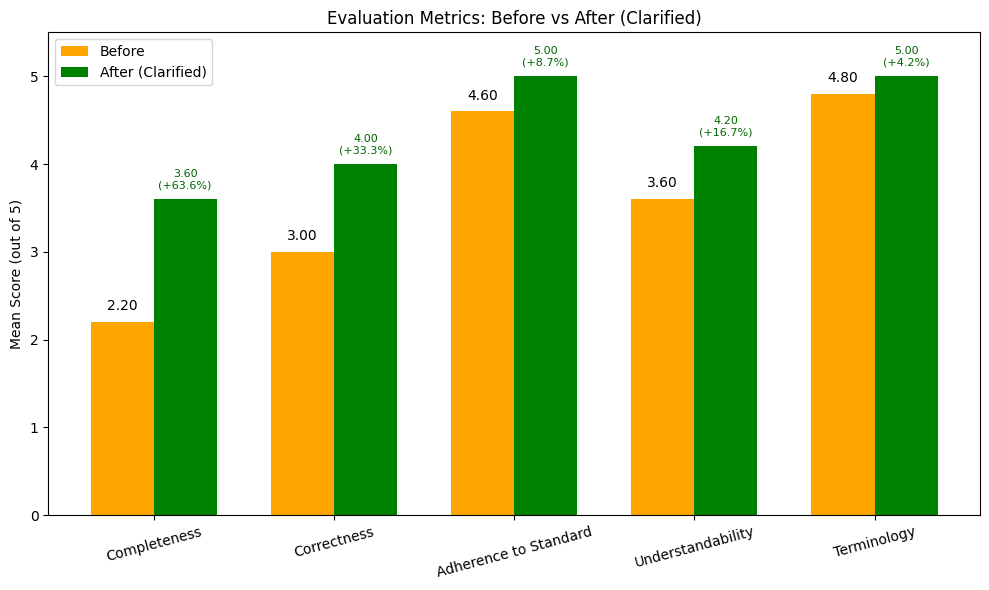

,Metric,Before Mean,After Mean,% Improvement (Mean)
0,Completeness,2.2,3.6,63.64
1,Correctness,3.0,4.0,33.33
2,Adherence to Standard,4.6,5.0,8.70
3,Understandability,3.6,4.2,16.67
4,Terminology,4.8,5.0,4.17


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_statistics_and_plot_single_chart(excel_file):
    df = pd.read_excel(excel_file)
    before_df = df[df['Version'] == 'before']
    after_df = df[df['Version'] == 'clarifiedAD']

    metrics = ["Completeness", "Correctness", "Adherence to Standard", "Understandability", "Terminology"]
    summary = []

    before_means = []
    after_means = []
    improvements = []

    for metric in metrics:
        before_mean = before_df[metric].mean()
        after_mean = after_df[metric].mean()
        improvement = ((after_mean - before_mean) / before_mean * 100) if before_mean != 0 else 0

        before_means.append(before_mean)
        after_means.append(after_mean)
        improvements.append(improvement)

        summary.append({
            "Metric": metric,
            "Before Mean": round(before_mean, 2),
            "After Mean": round(after_mean, 2),
            "% Improvement (Mean)": round(improvement, 2)
        })

    summary_df = pd.DataFrame(summary)
    summary_df.to_excel("evaluation_summary.xlsx", index=False)
    print("Summary saved to evaluation_summary.xlsx")

    # --- Plotting single grouped bar chart ---
    x = np.arange(len(metrics))  # label locations
    width = 0.35  # width of bars

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, before_means, width, label='Before', color='orange')
    bars2 = ax.bar(x + width/2, after_means, width, label='After (Clarified)', color='green')

    # Labels, title, legend
    ax.set_ylabel('Mean Score (out of 5)')
    ax.set_title('Evaluation Metrics: Before vs After (Clarified)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=15)
    ax.set_ylim(0, 5.5)
    ax.legend()

    # Annotate bars
    for i in range(len(metrics)):
        ax.text(x[i] - width/2, before_means[i] + 0.1, f'{before_means[i]:.2f}', ha='center', va='bottom')
        ax.text(x[i] + width/2, after_means[i] + 0.1, f'{after_means[i]:.2f}\n(+{improvements[i]:.1f}%)', 
                ha='center', va='bottom', fontsize=8, color='darkgreen')

    plt.tight_layout()
    plt.savefig("grouped_metrics_bar_chart.png")
    plt.show()

    return summary_df

# Run it
calculate_statistics_and_plot_single_chart("final_scores_gemini.xlsx")

In [11]:
import pandas as pd
from scipy.stats import ttest_rel

def perform_t_tests(excel_file):
    df = pd.read_excel(excel_file)
    before_df = df[df['Version'] == 'before'].sort_values(by="Problem")
    after_df = df[df['Version'] == 'clarifiedAD'].sort_values(by="Problem")

    metrics = ["Completeness", "Correctness", "Adherence to Standard", "Understandability", "Terminology"]

    results = []

    for metric in metrics:
        before_scores = before_df[metric].values
        after_scores = after_df[metric].values

        # Paired (dependent) t-test
        t_stat, p_value = ttest_rel(after_scores, before_scores)

        # Interpretation
        significance = "Significant" if p_value < 0.05 else "Not Significant"

        results.append({
            "Metric": metric,
            "Before Mean": round(before_scores.mean(), 2),
            "After Mean": round(after_scores.mean(), 2),
            "T-Statistic": round(t_stat, 4),
            "P-Value": round(p_value, 4),
            "Significance (p < 0.05)": significance
        })

    ttest_df = pd.DataFrame(results)
    ttest_df.to_excel("t_test_results.xlsx", index=False)
    print("T-test results saved to t_test_results.xlsx")
    return ttest_df

# Run it
perform_t_tests("final_scores_gemini.xlsx")


T-test results saved to t_test_results.xlsx


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,Metric,Before Mean,After Mean,T-Statistic,P-Value,Significance (p < 0.05)
0,Completeness,2.2,3.6,5.7155,0.0046,Significant
1,Correctness,3.0,4.0,inf,0.0000,Significant
2,Adherence to Standard,4.6,5.0,1.6330,0.1778,Not Significant
3,Understandability,3.6,4.2,2.4495,0.0705,Not Significant
4,Terminology,4.8,5.0,1.0000,0.3739,Not Significant


### old code

In [ ]:
import ollama
import json
import re

def evaluate_activity_diagram(problem_statement, plantuml_script):
    """
    Evaluates the quality of a generated activity diagram based on completeness and correctness
    using an LLM. Also generates a questionnaire for improvement.
    """
    prompt = f"""
    You are an expert UML analyst. Your task is to verify the **completeness and correctness**
    of a generated **Activity Diagram** (AD) given a system's **problem statement**.

    ## Step-by-Step:
    1. Parse and understand the problem statement.
    2. Analyze the provided PlantUML activity diagram script:
        - Check whether key system behaviors are represented.
        - Check that the flow of control (initial → actions → decisions/merges → final) is logically valid.
        - Identify any missing nodes, transitions, or incorrect flows.

    3. Evaluate on two key metrics:
        - Correctness: Is the control flow logically and syntactically valid?
        - Completeness: Are all key use cases/actions represented?

    4. Generate a questionnaire to guide refinement:
        - Include exactly 5 questions aimed at improving missing or incorrect areas.
        - Mention the exact part of the AD where the improvement is needed which should contain syntax errors or missing elements.
        - Ensure the questions are clear and actionable.


    Output Format (Strict JSON):
    {{
        "evaluation": {{
            "correctness": "pass/fail/partial",
            "completeness": "pass/fail/partial",
            "comments": ["comment1", "comment2", "..."]
        }},
        "questionnaire": [
            "Question 1: ...",
            "Question 2: ...",
            "... (exactly 5)"
        ]
    }}

    ## Problem Statement:
    {problem_statement}

    ## PlantUML Activity Diagram Script:
    {plantuml_script}

    Now evaluate and provide actionable feedback and questions.
    """

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        response_text = response.text.strip()

        # Remove markdown formatting if any
        cleaned_text = re.sub(r"```json|```", "", response_text).strip()
        output = json.loads(cleaned_text)
        return output

    except json.JSONDecodeError as e:
        print("JSON parsing error:", str(e))
        print("Response:", response_text)
        return {}

    except Exception as e:
        print("Error:", str(e))
        return {}

def regenerate_activity_diagram(problem_statement, previous_diagram, feedback, output_file="updatedAD.puml"):
    """
    Uses an LLM to regenerate an improved PlantUML activity diagram based on evaluation feedback.
    """
    comments = "\n".join(f"- {c}" for c in feedback["evaluation"].get("comments", []))
    questions = "\n".join(f"- {q}" for q in feedback.get("questionnaire", []))

    prompt = f"""
    You are a senior UML designer. Improve the PlantUML activity diagram based on feedback.

    ## Problem Statement:
    {problem_statement}

    ## Previous PlantUML Diagram:
    {previous_diagram}

    ## Feedback to Improve:
    ### Issues:
    {comments}

    ### Questionnaire with User Answers:
    {questions}

    ## Instructions:
    - Modify and enhance the PlantUML activity diagram to address all issues.
    - Ensure logical control flows and completeness.
    - Add decision branches, error handling, and promote clarity.
    - Start with @startuml and end with @enduml.
    - Return only the PlantUML script.
    """

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        response_text = response.text.strip()

        # Remove markdown formatting if needed
        cleaned_text = re.sub(r"```(plantuml|uml|text)?|```", "", response_text).strip()

        # Save to file
        with open(output_file, "w") as file:
            file.write(cleaned_text)

        return cleaned_text

    except Exception as e:
        print("Error:", str(e))
        return None

# def interactive_improvement_loop(problem_statement, initial_plantuml):
#     """proves the AD until it is marked co
#     Repeatedly evaluates and immplete and correct.
#     """
#     current_diagram = initial_plantuml
#     round_num = 1

#     while True:
#         print(f"\n🔁 Evaluation Round {round_num}")
#         eval_result = evaluate_activity_diagram(problem_statement, current_diagram)

#         correctness = eval_result.get("evaluation", {}).get("correctness", "").lower()
#         completeness = eval_result.get("evaluation", {}).get("completeness", "").lower()

#         if correctness == "pass" and completeness == "pass":
#             print("\n✅ Activity Diagram is complete and correct!")
#             break

#         print("\n📝 Evaluation Comments:")
#         for comment in eval_result["evaluation"].get("comments", []):
#             print(f" - {comment}")

#         print("\n🧠 Please answer the following questions to improve the diagram:")
#         user_answers = []
#         for q in eval_result.get("questionnaire", []):
#             print(q)
#             user_input = input("Your answer: ")
#             user_answers.append(f"{q} User Answer: {user_input}")

#         updated_feedback = {
#             "evaluation": eval_result["evaluation"],
#             "questionnaire": user_answers
#         }

#         current_diagram = regenerate_activity_diagram(
#             problem_statement=problem_statement,
#             previous_diagram=current_diagram,
#             feedback=updated_feedback,
#             output_file=f"updatedAD_round{round_num}.puml"
#         )

#         round_num += 1

#     return current_diagram

def answer_questions_with_llm(problem_statement, plantuml_script, questions):
    """
    Uses an LLM to automatically answer the questionnaire questions based on the diagram and problem statement.
    """
    q_block = "\n".join(f"{i+1}. {q}" for i, q in enumerate(questions))

    prompt = f"""
    You are a UML and software modeling expert.

    Based on the following **system problem statement** and the **PlantUML activity diagram**, 
    answer the improvement questionnaire questions to refine the diagram.

    ## Problem Statement:
    {problem_statement}

    ## PlantUML Activity Diagram:
    {plantuml_script}

    ## Questionnaire:
    {q_block}

    Provide detailed but concise answers to each question, matching the question number.

    ### Answer Format (as list):
    1. Answer to Question 1
    2. Answer to Question 2
    ...
    """

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.4})
        response_text = response.text.strip()

        print("\n🤖 LLM Answers to Questionnaire:\n", response_text)

        # Extract answers as list
        raw_lines = response_text.strip().split("\n")
        answers = [line.strip() for line in raw_lines if line.strip()]
        combined = [f"{questions[i]} LLM Answer: {answers[i]}" for i in range(min(len(questions), len(answers)))]
        return combined

    except Exception as e:
        print("Error during LLM question answering:", str(e))
        return [f"{q} LLM Answer: [Error generating answer]" for q in questions]          

def interactive_improvement_loop(problem_statement, initial_plantuml):
    """
    Automatically evaluates and improves the activity diagram until it is complete and correct.
    Uses LLM-generated answers to the questionnaire (no user input needed).
    """
    current_diagram = initial_plantuml
    round_num = 1

    while round_num <= 5:  # Limit to 5 rounds for safety
        print(f"\n🔁 Evaluation Round {round_num}")
        eval_result = evaluate_activity_diagram(problem_statement, current_diagram)

        correctness = eval_result.get("evaluation", {}).get("correctness", "").lower()
        completeness = eval_result.get("evaluation", {}).get("completeness", "").lower()

        if correctness == "pass" and completeness == "pass":
            print("\n✅ Activity Diagram is complete and correct!")
            break

        print("\n📝 Evaluation Comments:")
        for comment in eval_result["evaluation"].get("comments", []):
            print(f" - {comment}")

        questionnaire = eval_result.get("questionnaire", [])
        if questionnaire:
            print("\n🤖 Generating LLM answers to improvement questions...")
            auto_answers = answer_questions_with_llm(problem_statement, current_diagram, questionnaire)
        else:
            auto_answers = []

        updated_feedback = {
            "evaluation": eval_result["evaluation"],
            "questionnaire": auto_answers
        }

        current_diagram = regenerate_activity_diagram(
            problem_statement=problem_statement,
            previous_diagram=current_diagram,
            feedback=updated_feedback,
            output_file=f"updatedAD_round{round_num}.puml"
        )

        round_num += 1

    return current_diagram


# Run the interactive improvement loop
final_diagram = interactive_improvement_loop(problem_statement, plantuml_code)


🔁 Evaluation Round 1

📝 Evaluation Comments:
 - The activity diagram is incomplete and has some logical flaws.
 - Several key aspects of the problem statement are missing, such as order status checking, handling different customer identification methods, and the distinction between web and phone interactions.
 - The flow for handling order cancellation and product returns is unclear and incomplete.
 - The condition for promoting to Gold Customer is missing.
 - The email notification signup is incorrectly placed within the payment validation section.

🤖 Generating LLM answers to improvement questions...

🤖 LLM Answers to Questionnaire:
 1. Answer to Question 1:  The initial node should be replaced with a decision node labeled "Interaction Method?".  Two branches will emerge: one labeled "Web" and the other "Phone".  The "identifyCustomer" activity will follow both branches, but subsequent activities might differ depending on the interaction method (e.g.,  catalog request might be more 

In [10]:
final_diagram

'@startuml\nstart\n\n:Interaction Method?;\nif (Web) then (true)\n    :Customer Identification?;\n    if (Customer Identified) then (true)\n        :Customer Identified;\n        :Check Order Status?;\n        if (yes) then (true)\n            :Display Order Status;\n        endif\n        :Request Catalog?;\n        if (yes) then (true)\n            :Send Catalog;\n        endif\n        :Select Product;\n        :Process Order;\n    else (false)\n        :Customer Identification Failed;\n        :Notify Customer of Failure;\n        stop\n    endif\nelse (false)\n    :Phone Interaction;\n    :Customer Identification?;\n    if (Customer Identified) then (true)\n        :Customer Identified;\n        :Check Order Status?;\n        if (yes) then (true)\n            :Display Order Status;\n        endif\n        :Request Catalog?;\n        if (yes) then (true)\n            :Send Catalog;\n        endif\n        :Select Product;\n        :Request Product Return?;\n        if (yes) then (t

In [ ]:
# # 1. Assume you already have:
# # problem_statement = ...
# # plantuml_code = ...

# # 2. Generate clarification questions
# questions = generate_clarification_questions(problem_statement, plantuml_code)
# print("\n🧠 Clarification Questions:")
# for q in questions:
#     print(q)

# # 3. Answer them automatically using LLM
# answers = answer_clarification_questions(problem_statement, plantuml_code, questions)
# print("\n🤖 Answers to Questions:")
# for a in answers:
#     print(a)

# # 4. Regenerate improved AD
# clarified_ad = regenerate_ad_from_feedback(problem_statement, plantuml_code, questions, answers)
# print("\n📌 Clarified Activity Diagram:")
# print(clarified_ad)


In [ ]:
def evaluate_activity_diagram(problem_statement, plantuml_script):
    """
    Evaluates the quality of a generated activity diagram based on completeness and correctness
    using an LLM. Also generates a questionnaire for improvement.
    """
    prompt = f"""
    You are an expert UML analyst. Your task is to verify the **completeness and correctness**
    of a generated **Activity Diagram** (AD) given a system's **problem statement**.

    ## Step-by-Step:
    1. **Parse and understand the problem statement**.
    2. **Analyze the provided PlantUML activity diagram script**:
        - Check whether key system behaviors are represented.
        - Check that the flow of control (initial → actions → decisions/merges → final) is logically valid.
        - Identify any missing nodes, transitions, or incorrect flows.

    3. Evaluate on two key metrics:
        - **Correctness**: Is the control flow logically and syntactically valid?
        - **Completeness**: Are all key use cases/actions represented?

    4. **Generate a questionnaire** to guide refinement:
        - Include at least 5 questions aimed at improving missing or incorrect areas.
        - Mention the exact part of the AD where the improvement is needed.

    ## Output Format (Strict JSON):
    {{
        "evaluation": {{
            "correctness": "pass/fail/partial",
            "completeness": "pass/fail/partial",
            "comments": ["comment1", "comment2", "..."]
        }},
        "questionnaire": [
            "Question 1: ...",
            "Question 2: ...",
            "... (at least 5)"
        ]
    }}

    ## Problem Statement:
    {problem_statement}

    ## PlantUML Activity Diagram Script:
    {plantuml_script}

    Now evaluate and provide actionable feedback and questions.
    """

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        response_text = response.text.strip()
        
        print("Raw Evaluation Response:\n", response_text)

        # Remove markdown formatting if any
        cleaned_text = re.sub(r"```json|```", "", response_text).strip()
        print("Cleaned Evaluation JSON:\n", repr(cleaned_text))

        output = json.loads(cleaned_text)
        return output

    except json.JSONDecodeError as e:
        print("JSON parsing error:", str(e))
        return {}

    except Exception as e:
        print("Error:", str(e))
        return {}

evaluation_result = evaluate_activity_diagram(problem_statement, plantuml_code)

# Display Result
print("\nGenerated Response:", evaluation_result)


Raw Evaluation Response:
 ```json
{
  "evaluation": {
    "correctness": "partial",
    "completeness": "partial",
    "comments": [
      "The activity diagram is incomplete and has some logical flaws.",
      "Several key aspects of the problem statement are missing, such as order status checking, handling different customer identification methods, and the distinction between web and phone interactions.",
      "The handling of gold customer promotions and benefits is incomplete and improperly placed.",
      "The flow for order cancellation and product return is unclear and not fully aligned with the problem statement.",
      "The diagram lacks error handling for various scenarios (e.g., invalid credit card, unavailable products)."
    ]
  },
  "questionnaire": [
    "Question 1: The diagram lacks the initial choice between web and phone interaction.  How should we represent the different entry points for customers (web vs. phone) and their respective functionalities (e.g., product

In [ ]:
def regenerate_activity_diagram(problem_statement, previous_diagram, feedback, output_file="updatedAD.puml"):
    """
    Uses an LLM to regenerate an improved PlantUML activity diagram based on evaluation feedback.
    
    Parameters:
    - problem_statement: Original system description.
    - previous_diagram: The initial PlantUML diagram script.
    - feedback: Dictionary with 'evaluation' and 'questionnaire' keys from previous evaluation.
    
    Returns:
    - Improved PlantUML script (str)
    """
    comments = "\n".join(f"- {c}" for c in feedback["evaluation"].get("comments", []))
    questions = "\n".join(f"- {q}" for q in feedback.get("questionnaire", []))

    prompt = f"""
    You are a senior UML designer. Your task is to improve the provided **PlantUML activity diagram**
    for the given system problem statement based on detailed feedback from a previous evaluation.

    ## Problem Statement:
    {problem_statement}

    ## Previous PlantUML Diagram:
    {previous_diagram}

    ## Feedback to Improve:
    ### Issues Identified:
    {comments}

    ### Improvement Questions:
    {questions}

    ## Instructions:
    - Modify and enhance the PlantUML activity diagram to address all issues and answer the improvement questions.
    - Ensure the diagram includes all key flows
    - Add missing nodes, transitions, error handling, and clearly represent decisions and branches.
    - The script must start with @startuml and end with @enduml.
    - Return only the improved PlantUML script.

    Generate the improved diagram below.
    """

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.0, "top_p": 1, "top_k": 1})
        response_text = response.text.strip()

        print("\nRaw Regeneration Response:\n", response_text)

        # Remove markdown formatting if needed
        cleaned_text = re.sub(r"```(plantuml|uml|text)?|```", "", response_text).strip()
        print("Cleaned Code:\n", repr(cleaned_text))

        # ✅ Save to file
        with open(output_file, "w") as file:
            file.write(cleaned_text)

        print(f"✅ PlantUML file '{output_file}' generated successfully.")

        return cleaned_text

    except Exception as e:
        print("Error:", str(e))
        return None

updated_plantuml = regenerate_activity_diagram(problem_statement, plantuml_code, evaluation_result)



Raw Regeneration Response:
 ```plantuml
@startuml
start

partition Customer Interaction {
    if (Interaction Method) then (Web)
        :Identify Customer (Customer Number or Name/Address);
        :Select Products;
        :Get Product Information (Price, Description, Picture (on demand), Availability);
        while (More Products?) is (yes)
            :Select Products;
            :Get Product Information (Price, Description, Picture (on demand), Availability);
        endwhile
        :Provide Shipping Address;
        :Provide Billing Address;
        :Provide Credit Card Number;
        :Submit Order;
    else (Phone)
        :Identify Customer (Customer Number or Name/Address);
        :Select Products;
        :Get Product Information (Price, Description, Availability);
        while (More Products?) is (yes)
            :Select Products;
            :Get Product Information (Price, Description, Availability);
        endwhile
        :Provide Shipping Address;
        :Prov

In [ ]:
def interactive_improvement_loop(problem_statement, initial_plantuml):
    current_diagram = initial_plantuml
    round_num = 1

    while True:
        print(f"\n🔎 Evaluation Round {round_num}")
        eval_result = evaluate_activity_diagram(problem_statement, current_diagram)

        correctness = eval_result.get("evaluation", {}).get("correctness", "").lower()
        completeness = eval_result.get("evaluation", {}).get("completeness", "").lower()
            
        if correctness == "pass" and completeness == "pass":
            print("\n✅ Activity Diagram is complete and correct.")
            break

        # Display evaluation summary to user
        print("\n📋 Comments for Improvement:")
        for comment in eval_result["evaluation"].get("comments", []):
            print(f" - {comment}")

        print("\n🧩 Questionnaire:")
        user_answers = []
        for question in eval_result.get("questionnaire", []):
            print(question)
            user_input = input("Your answer: ")
            user_answers.append(f"{question} User Answer: {user_input}")

        # Inject user responses back into the regeneration prompt
        updated_feedback = {
            "evaluation": eval_result["evaluation"],
            "questionnaire": user_answers
        }

        # Regenerate the activity diagram
        current_diagram = regenerate_activity_diagram(
            problem_statement=problem_statement,
            previous_diagram=current_diagram,
            feedback=updated_feedback,
            output_file=f"improvedAD_round{round_num}.puml"
        )

        round_num += 1

    return current_diagram


### Debugging...

In [ ]:
import os

def generate_plantuml(nodes, control_flow, output_file="debug.puml"):
    """
    Generates a PlantUML activity diagram script from identified nodes and control flow.
    """
    
    prompt = f"""
    You are an expert UML Diagram Developer. Your task is to generate plantUML script for defined activity nodes and control flows for an activity diagram.

    **Defined Nodes:**
    {nodes}

    **Defined Control_flow**
    {control_flow}

    Now generate the PlantUML activity diagram. 
    **Return only the PlantUML code.**  
    """
    

    try:
        # Generate response using Gemini model
        model = genai.GenerativeModel("gemini-1.5-flash")
        response = model.generate_content(prompt, generation_config={"temperature": 0.7, "top_p": 1, "top_k": 1})
        
        # Debugging: Print raw response
        response_text = response.text.strip()
        print("Raw Response from Gemini:\n", response_text)

        # Clean up response (remove markdown formatting)
        cleaned_text = re.sub(r"```plantuml|```", "", response_text).strip()

        # Additional Debugging: Print cleaned text before saving
        print("Cleaned Code:\n", repr(cleaned_text))

        # ✅ Save to file
        with open(output_file, "w") as file:
            file.write(cleaned_text)

        print(f"✅ PlantUML file '{output_file}' generated successfully.")

        return cleaned_text

    except Exception as e:
        print("Error:", str(e))
        return None

# Generate UML
plantuml_code = generate_plantuml(identified_nodes, control_flow)

# ✅ To render, use:
# `plantuml output.puml`

Raw Response from Gemini:
 ```plantuml
@startuml
start

:Start Process;

if (Condition A?) then (Yes)
  :Action 1;
  :Action 2;
else (No)
  :Action 3;
  :Action 4;
endif

:End Process;

stop
@enduml
```
Cleaned Code:
 '@startuml\nstart\n\n:Start Process;\n\nif (Condition A?) then (Yes)\n  :Action 1;\n  :Action 2;\nelse (No)\n  :Action 3;\n  :Action 4;\nendif\n\n:End Process;\n\nstop\n@enduml'
✅ PlantUML file 'debug.puml' generated successfully.
